## HMM-based sand manipulation detection

The 15-minute video has been split into 10-second chunks, stored in the `clipped_clips` folder. I plan to run a series of experiments on these shorter videos that involve the following steps:

1. **Frame Extraction:** Extract frames from each 10-second video clip at a specified frame rate.

2. **Feature Extraction and Noise Filtering:** Extract features from the frames using LBP, filter out noisy data, and interpolate noisy pixels.

3. **Dimensionality Reduction:** Reduce the dimensionality of the extracted features using Principal Component Analysis (PCA).

4. **Hidden Markov Model (HMM) Analysis:** Apply an HMM to predict states for each frame based on the reduced feature set.

5. **DBSCAN Clustering:** Use DBSCAN clustering to analyze the predicted states and identify instances of sand manipulation that are distinct from fish movements.

6. **Visualization and Heuristic Refinement:** Visualize the detected sand manipulation regions and refine the heuristics based on the results to improve accuracy.

These experiments aim to accurately differentiate between sand manipulation events and fish movements, thereby improving the analysis of the video data.

### Mount Google Drive and Install Required Packages

The cells below mount Google Drive to access the files stored in it and install required packages, such as PyTorch, torchvision, ffmeg, av, and hmmlearn, which are necessary for subsequent code execution.

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch torchvision
!sudo apt update
!sudo apt install ffmpeg
!pip install av
!pip install hmmlearn

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

### Define paths and create necessary directories

This cell sets up the paths for the input video file, the output file, and the directory for storing video clips. It also creates the directory if it does not already exist.

In [ ]:
import os

# Define paths
video_file = "/content/drive/MyDrive/OMSCS/Cichlids/clipped_file_15mins.mp4"
output_file = "/content/drive/MyDrive/OMSCS/Cichlids/clipped_clips/example.npy"
clips_dir = "/content/drive/MyDrive/OMSCS/Cichlids/clipped_clips"

# Create the directory if it does not exist
if not os.path.exists(clips_dir):
    os.makedirs(clips_dir)

### Video Clipper Class Definition

This section defines the VideoClipper class, which splits the input video into smaller clips. The class includes methods for initializing the video clipper, saving clips, and running the clipper to process the video.

In [ ]:
""" BEGIN CODE FROM https://raw.githubusercontent.com/Human-Augment-Analytics/CichlidBowerTracking/master/cichlid_bower_tracking/data_distillation/data/video_clipper.py"""
from typing import List
import math, os
from torchvision.io import read_video, write_video
import torch

class VideoClipper:
    def __init__(self, video_index: int, video_file: str, clips_dir: str, fps=30, fpc=300, debug=False):
        self.video_index = video_index
        self.video_file = video_file
        self.clips_dir = clips_dir
        self.fpc = fpc
        self.fps = fps
        self.debug = debug
        self.clip_count = 0

    def _save_clip(self, clip: torch.Tensor) -> None:
        filename = f'{str(self.clip_count + 1).zfill(9)}.mp4'
        filename = os.path.join(self.clips_dir, filename)
        video_codec = 'h264'
        if self.debug:
            print(f'\t...writing clip {filename}')
        write_video(filename, clip, self.fps, video_codec=video_codec)

    def run(self) -> None:
        prev = None
        start_idx = 0.0
        spc = self.fpc / self.fps
        clip = torch.randn(2)
        while torch.numel(clip) > 0:
            clip = read_video(filename=self.video_file, start_pts=start_idx, end_pts=start_idx + spc - (1/self.fps), pts_unit='sec', output_format='THWC')[0]
            if clip.shape[0] == 1:
                if prev is None:
                    prev = clip
                elif prev is not None and torch.equal(prev, clip):
                    break
            self._save_clip(clip=clip)
            self.clip_count += 1
            start_idx += spc
""" END CODE FROM https://raw.githubusercontent.com/Human-Augment-Analytics/CichlidBowerTracking/master/cichlid_bower_tracking/data_distillation/data/video_clipper.py"""

' END CODE FROM https://raw.githubusercontent.com/Human-Augment-Analytics/CichlidBowerTracking/master/cichlid_bower_tracking/data_distillation/data/video_clipper.py'

### Initialize and Run the Video Clipper

This cell creates an instance of the VideoClipper class and runs it to process the input video file.

In [ ]:
# Initialize and run the VideoClipper
clipper = VideoClipper(video_index=1, video_file=video_file, clips_dir=clips_dir, fps=30, fpc=300, debug=True)
clipper.run()

	...writing clip /content/drive/MyDrive/OMSCS/Cichlids/clipped_clips/000000001.mp4
	...writing clip /content/drive/MyDrive/OMSCS/Cichlids/clipped_clips/000000002.mp4
	...writing clip /content/drive/MyDrive/OMSCS/Cichlids/clipped_clips/000000003.mp4
	...writing clip /content/drive/MyDrive/OMSCS/Cichlids/clipped_clips/000000004.mp4
	...writing clip /content/drive/MyDrive/OMSCS/Cichlids/clipped_clips/000000005.mp4
	...writing clip /content/drive/MyDrive/OMSCS/Cichlids/clipped_clips/000000006.mp4
	...writing clip /content/drive/MyDrive/OMSCS/Cichlids/clipped_clips/000000007.mp4
	...writing clip /content/drive/MyDrive/OMSCS/Cichlids/clipped_clips/000000008.mp4
	...writing clip /content/drive/MyDrive/OMSCS/Cichlids/clipped_clips/000000009.mp4
	...writing clip /content/drive/MyDrive/OMSCS/Cichlids/clipped_clips/000000010.mp4
	...writing clip /content/drive/MyDrive/OMSCS/Cichlids/clipped_clips/000000011.mp4
	...writing clip /content/drive/MyDrive/OMSCS/Cichlids/clipped_clips/000000012.mp4
	...

### Extract Frames from Video Clips

This section includes functions to extract frames from the video clips at a specified frame rate. It reads all video files in the specified directory and extracts frames from each video.

In [ ]:
import cv2
import os

def extract_frames(video_path, frame_rate=30):
    cap = cv2.VideoCapture(video_path)
    frames = []
    count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if count % frame_rate == 0:
            frames.append(frame)
        count += 1
    cap.release()
    return frames

def read_videos_and_extract_frames(directory, frame_rate=30):
    all_frames = []
    video_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.mp4')]
    for video_path in video_files:
        frames = extract_frames(video_path, frame_rate)
        all_frames.extend(frames)
    return all_frames

directory = '/content/drive/MyDrive/OMSCS/Cichlids/clipped_clips/'
all_frames = read_videos_and_extract_frames(directory)

# To verify the number of frames extracted
print(f"Number of frames extracted: {len(all_frames)}")

Number of frames extracted: 917


### Set Environment Variables and Import Libraries

This cell sets environment variables to control the number of threads used by various libraries. It also imports required libraries for further processing.

In [ ]:
import os
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['VECLIB_MAXIMUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'

import warnings ; warnings.filterwarnings('ignore')
import numpy as np
import scipy.ndimage.filters
import hmmlearn
from hmmlearn import hmm

### Define Parameters for Processing

This cell sets various parameters that will be used for filtering and analyzing the frames, such as the mean window, mean cushion, HMM window, etc.

In [ ]:
""" Define parameters """
mean_window = 120           # How many seconds does it take to calculate means for filtering out the noisy data
mean_cushion = 7.5          # Grayscale change in pixel value for filtering out large pixel changes for HMM analysis
hmm_window = 10             # Used for reducing the number of states for HMM calculation
seconds_to_change = 1800    # Used to determine the transition expectation from one state to another (i.e., how many manipulations occur)
non_transition_bins = 2     # Parameter to prevent small changes in the state
std = 100                   # Standard deviation of pixel data in HMM analysis

### Define functions for interpolating noisy pixels and extracting features

This section includes a function to interpolate noisy pixels in a frame and another function to extract Local Binary Pattern (LBP) features from a frame.

#### What does a uniform filter do?

1.   **Smoothing**: Reduces noise and high-frequency details, resulting in a smoother image.
2.   **Edge Preservation**: Preserves edges to some extent due to the equal weight distribution within the filter.
3.   **Background Extraction**: Can help reduce background clutter by averaging local pixel values.

#### Steps taken below:

1. **Noise Handling**: You identify noisy frames and interpolate them using `interpolate_noisy_pixels`.
2. **Feature Extraction**: Extracting features from each frame using LBP (Local Binary Patterns). It captures local texture patterns in an image. This can be helpful for identifying changes in sand texture caused by manipulation.
3. **HMM Training**: Now I am training the HMM on the extracted features to predict the hidden states for each frame.
4. **Clustering**: Using DBSCAN clustering on the predicted states (treated as features) to group similar frames.
5. **Sand Manipulation Identification**: I could identify frames potentially associated with sand manipulation based on the clustering results.



In [ ]:
from scipy.ndimage import uniform_filter, median_filter
from skimage.feature import local_binary_pattern
from scipy.interpolate import griddata
import numpy as np

def interpolate_noisy_pixels(frame, noisy_pixels):
    # Convert the noisy_pixels to mask for OpenCV (invert for non-noisy pixels)
    mask = np.logical_not(noisy_pixels)
    # Use OpenCV's bilinear interpolation with boundary handling
    interpolated_frame = cv2.filter2D(frame.astype('float32'), -1, mask.astype('float32'), borderType=cv2.BORDER_REPLICATE)
    # Fill the remaining noisy pixels (if any) with the original value (or another strategy)
    interpolated_frame[noisy_pixels] = frame[noisy_pixels]
    return interpolated_frame.astype('uint8')

def extract_features(frame):
    # Extract LBP features from the frame
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray_frame, 8, 1, method='uniform')
    return lbp.flatten()

### Process Frames to Identify and Interpolate Noisy Data, Extract Features

This cell processes each frame to identify noisy pixels, interpolate them, and extract features using LBP. The results are stored in arrays for further analysis.

In [ ]:
frames = all_frames  # Assuming `all_frames` is a list or numpy array of frames
filtered_frames = np.empty_like(frames)
threshold_multiplier = 3.82  # Adjust this value to change sensitivity
noisy_indices = []
features = []

for i in range(len(frames)):
    frame = frames[i]
    filtered_frame = uniform_filter(frame, size=3, mode='reflect').astype('uint8')
    frame_std = np.std(frame)
    noisy_pixels = np.abs(frame - filtered_frame) > threshold_multiplier * frame_std
    if np.any(noisy_pixels):
        #print(f"Frame {i} has noisy data.")
        frames[i] = interpolate_noisy_pixels(frame, noisy_pixels)  # Interpolate noisy pixels in the frame
        noisy_indices.append(i)
    filtered_frames[i] = filtered_frame
    features.append(extract_features(frames[i]))  # Extract features for each frame

if noisy_indices:
    print("Frames with noisy data:", noisy_indices)
else:
    print("No frames with noisy data found.")

Frames with noisy data: [0, 2, 569, 571, 591, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 625, 627, 628, 629, 630, 631, 632, 633, 634, 635, 637, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 675, 677, 679, 681, 684, 685, 687, 688, 689, 690, 691, 693, 694, 695, 696, 697, 699, 700, 701, 702, 703, 705, 706, 707, 708, 709, 710, 711, 715, 716, 717, 721, 729, 740, 741]


### Dimensionality Reduction with PCA and HMM State Prediction

This section reduces the feature dimensionality using PCA and applies an HMM to predict states for each frame.

In [ ]:
from sklearn.decomposition import PCA

features_array = np.array(features)

# Reduce feature dimensionality using PCA
pca = PCA(n_components=0.8)
features_reduced = pca.fit_transform(features_array)

# Define the HMM model with adjusted parameters
n_components = 5    # Number of states in HMM, adjust based on use case
model = hmm.GaussianHMM(n_components=n_components, covariance_type="diag", n_iter=50)

# Train the HMM model
model.fit(features_reduced)

# Predict the states for each frame (example)
predicted_states = model.predict(features_reduced)
print("Predicted states for each frame:\n", predicted_states)

Predicted states for each frame:
 [3 2 3 2 2 2 2 2 2 2 0 0 0 2 2 2 2 2 2 2 0 0 0 2 2 2 2 2 2 2 0 0 0 2 2 2 2
 2 2 2 0 0 0 2 2 2 2 2 2 2 0 0 0 2 2 2 2 2 2 2 0 0 0 2 2 2 2 2 2 2 0 0 0 2
 2 2 2 2 2 2 0 0 0 2 2 2 2 2 2 2 0 0 0 2 2 2 2 2 2 2 0 0 0 2 2 2 2 2 2 2 0
 0 0 2 2 2 2 2 2 2 0 0 0 2 2 2 2 2 2 2 0 0 0 2 2 2 2 2 2 2 0 0 0 2 2 2 2 2
 2 2 0 0 0 0 2 2 2 2 2 2 0 0 0 2 2 2 2 2 2 2 0 0 0 2 2 2 2 2 2 2 0 0 0 2 2
 2 2 2 2 2 0 0 0 2 2 2 2 2 2 2 0 0 0 2 2 2 2 2 2 2 0 0 0 2 2 2 2 2 2 2 0 0
 0 2 2 2 2 2 2 2 0 0 0 2 2 2 2 2 2 2 0 0 0 2 2 2 2 2 2 2 0 0 0 2 2 2 2 2 2
 2 0 0 0 2 2 2 2 2 2 2 0 0 0 2 2 2 2 2 2 2 0 0 0 2 2 2 2 2 2 2 0 0 0 2 2 2
 2 2 2 2 0 0 0 2 2 2 2 2 2 2 0 0 0 2 2 2 2 2 2 2 0 0 0 2 2 2 2 2 2 2 0 0 0
 2 2 2 2 2 2 2 0 0 0 2 2 2 2 2 2 2 0 0 0 2 2 2 2 2 2 2 0 0 0 2 2 2 2 2 2 2
 0 0 0 2 2 2 2 2 2 2 0 0 0 2 2 2 2 2 2 2 0 0 0 2 2 2 2 2 2 2 0 0 0 2 2 2 2
 2 2 2 0 0 0 2 2 2 2 2 2 2 0 0 0 2 2 2 2 2 2 2 0 0 0 2 2 2 2 2 2 2 0 0 0 0
 2 2 2 2 2 2 0 0 0 2 2 2 2 2 2 2 0 0 0 2 2 2 2 2 2 2 0 0 0 2 2 2 2

### Apply DBSCAN Clustering to Predicted States

This cell applies the DBSCAN algorithm to cluster the predicted states and visualizes the clusters using a scatter plot.

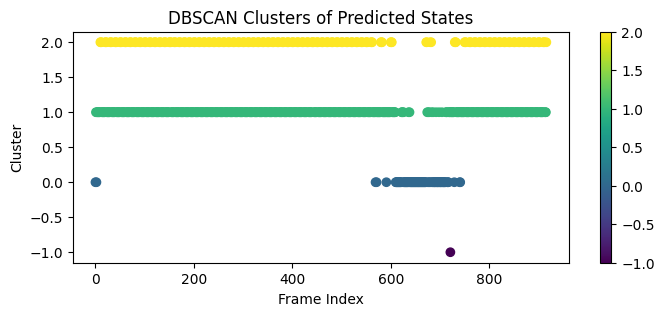

Cluster -1: [721]
Cluster 0: [  0   2 569 571 591 610 611 612 613 614 615 616 617 618 619 620 621 625
 627 628 629 630 631 632 633 634 635 637 639 640 641 642 643 644 645 646
 647 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664
 665 666 667 668 669 670 671 675 677 679 681 684 685 687 688 689 690 691
 693 694 695 696 697 699 700 701 702 703 705 706 707 708 709 710 711 715
 716 717 729 740 741]
Cluster 1: [  1   3   4   5   6   7   8   9  13  14  15  16  17  18  19  23  24  25
  26  27  28  29  33  34  35  36  37  38  39  43  44  45  46  47  48  49
  53  54  55  56  57  58  59  63  64  65  66  67  68  69  73  74  75  76
  77  78  79  83  84  85  86  87  88  89  93  94  95  96  97  98  99 103
 104 105 106 107 108 109 113 114 115 116 117 118 119 123 124 125 126 127
 128 129 133 134 135 136 137 138 139 143 144 145 146 147 148 149 154 155
 156 157 158 159 163 164 165 166 167 168 169 173 174 175 176 177 178 179
 183 184 185 186 187 188 189 193 194 195 196 197 198 199 203 2

In [ ]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# Apply DBSCAN to the predicted states
dbscan = DBSCAN(eps=0.5, min_samples=5)
predicted_states = predicted_states.reshape(-1, 1)  # Reshape for DBSCAN
clusters = dbscan.fit_predict(predicted_states)

# Plot the clusters
plt.figure(figsize=(8, 3))
plt.scatter(np.arange(len(clusters)), clusters, c=clusters, cmap='viridis', marker='o')
plt.title('DBSCAN Clusters of Predicted States')
plt.xlabel('Frame Index')
plt.ylabel('Cluster')
plt.colorbar()
plt.show()

# Analyze the clusters
unique_clusters = np.unique(clusters)
for cluster in unique_clusters:
    cluster_indices = np.where(clusters == cluster)[0]
    print(f"Cluster {cluster}: {cluster_indices}")

### Graveyard

All code cells that I tried experimenting with, but ultimately led me down another, more fruitful direction.

In [ ]:
# Loading the data
frames_data = all_frames

# Processing each frame
output_data = []

for i, frame in enumerate(frames_data):
    # Calculate means over mean_window parameter
    mean_values = scipy.ndimage.filters.uniform_filter(frame, size=(1, mean_window), mode='reflect').astype('uint8')

    # Identify data that falls outside of mean using mean_cushion
    noisy_indices = (((frame > mean_values + mean_cushion) | (frame < mean_values - mean_cushion)))
    frame[noisy_indices] = 0

    # Interpolate noisy data for HMM
    nan_indices = frame == 0
    x = lambda z: z.nonzero()[0]
    frame[nan_indices] = np.interp(x(nan_indices), x(~nan_indices), frame[~nan_indices])

    # Collect HMM for the frame
    means = scipy.ndimage.filters.uniform_filter(frame, size=hmm_window, mode='reflect').astype('uint8')
    freq, bins = np.histogram(means, bins=range(0, 257, 2))
    states = bins[:-1][freq > hmm_window]
    n_states = len(states)

    # Build the HMM model
    model = hmm.GaussianHMM(n_components=n_states, covariance_type='spherical')
    model.startprob_ = np.full(n_states, 1 / n_states)

    change = 1 / seconds_to_change    # Probability of transitioning states

    # Creating the transition matrix
    trans = np.zeros((n_states, n_states))
    for k, state in enumerate(states):
        s_trans = np.zeros(states.shape)
        n_trans_states = np.count_nonzero(
            (states > state + non_transition_bins) | (states < state - non_transition_bins)
        )
        if n_trans_states != 0:
            s_trans[(states > state + non_transition_bins) | (state < state - non_transition_bins)] = change / n_trans_states
            s_trans[states == state] = 1 - change
        else:
            s_trans[states == state] = 1
        trans[k] = s_trans

    model.transmat_ = trans
    model.means_ = states.reshape(-1, 1)
    model.covars_ = np.full(n_states, std)

    # Predict using the HMM model
    predicted_states = model.predict(frame.reshape(-1, 1))

    # Collect results
    for j, state in enumerate(predicted_states):
        output_data([j, state, i])  # Modify output as needed

output_data = np.array(output_data)
np.save('hmm_results.npy', output_data)

In [ ]:
import cv2

def background_subtraction(video_path):
    cap = cv2.VideoCapture(video_path)
    fgbg = cv2.createBackgroundSubtractorMOG2()

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
          break
        fgmask = fgbg.apply(frame)
        cv2.imshow('Frame', frame)
        cv2.imshow('FG Mask', fgmask)

        if cv2.waitKey(30) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

long_video = '/content/drive/MyDrive/OMSCS/Cichlids/clipped_file_15mins.mp4'
background_subtraction(long_video)

In [ ]:
from sklearn.cluster import DBSCAN

def detect_sand_manipulation(flow, mag_threshold=1.0, eps=3, min_samples=5):
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    significant_movement = mag > mag_threshold
    movement_coords = np.column_stack(np.nonzero(significant_movement))

    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(movement_coords)
    labels = clustering.labels_
    unique_labels = set(labels)

    sand_clusters = []
    for label in unique_labels:
        if label != -1:
            cluster_coords = movement_coords[labels == label]
            sand_clusters.append(cluster_coords)

    return sand_clusters

In [ ]:
import matplotlib.pyplot as plt

def visualize_clusters(frame, clusters):
    for cluster in clusters:
        for coord in cluster:
            cv2.circle(frame, (coord[1], coord[0]), 2, (0, 255, 0), -1)
    cv2.imshow('Sand Manipulation', frame)
    cv2.waitKey(0)

In [ ]:
import numpy as np
import cv2

def compute_optical_flow(video_path):
    cap = cv2.VideoCapture(video_path)
    ret, prev_frame = cap.read()
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

    while cap.isOpened():
        ret, next_frame = cap.read()
        if not ret:
            break
        next_gray = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)
        flow = cv2.calcOpticalFlowFarneback(prev_gray, next_gray, None, 0.5, 3, 15, 3, 5, , 1.2, 0)
        sand_clusters = detect_sand_manipulation(flow)
        visualize_clusters(next_frame, sand_clusters)

        # Visualization
        hsv = np.zeros_like(prev_frame)
        hsv[..., 1] = 255
        mag, ang = cv2.CartToPolar(flow[..., 0], flow[..., 1])
        hsv[..., 0] = ang * 100 / np.pi / 2
        hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
        bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

        cv2.imshow('Frame', next_frame)
        cv2.imshow('Optical Flow', bgr)

        if cv2.waitKey(30) & 0xFF == ord('q'):
            break

        prev_gray = next_gray

    cap.release()
    cv2.destroyAllWindows()